In [96]:
import polars as pl
import pandas as pd
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timezone

start_date = datetime(2023, 7, 30, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 7, 30, 23, 59, 59).replace(tzinfo=timezone.utc)

data = {"date": [],
        "system name": [],
        "variant": [],
        "CO2_raw": [],
        "CO2_compensated": [],
        "CO2_filtered": [],
        "sht45_humidity": [],
        "bme280_humidity": [],
        "bme280_pressure": [],
        "sht45_temperature": [],
        "bme280_temperature": [],
        "chamber_temperature": [],
        "gas_bottle_id": []}

In [97]:
df_gas = pl.read_csv("../data/averaged_gases.csv")
df_gas

Bottle_ID,CO2_dry
i64,f64
1,798.115438
2,807.238809
3,391.345476
4,399.530674
5,416.594961
6,401.541294
7,403.088251
8,417.417491
9,805.549024


In [98]:
quickflow_directory = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/quickflow/notebooks/acropolis/"
df_quickflow = pl.scan_parquet(os.path.join(quickflow_directory, "measurements.parquet")) 

In [99]:
# loop through the quickflow dataset and sort it into dataframe
df_q = df_quickflow.select(pl.col("creation_timestamp","sensor_name","value")).sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date)).collect()

for payload in df_q.iter_rows():
    creation_timestamp = payload[0]
    sensor_name = payload[1]
    entry = json.loads(payload[2])
    
    if entry["variant"] in ("measurement","calibration"):
        # base
        data["date"].append(creation_timestamp)
        data["system name"].append(sensor_name)
        data["variant"].append(entry["variant"])
        #variant measurement & calibrtion
        data["CO2_raw"].append(entry["data"]["raw"])
        data["CO2_compensated"].append(entry["data"]["compensated"])
        data["CO2_filtered"].append(entry["data"]["compensated"])
        data["sht45_humidity"].append(entry["data"]["sht45_humidity"])
        data["bme280_humidity"].append(entry["data"]["bme280_humidity"])
        data["bme280_pressure"].append(entry["data"]["bme280_pressure"])
        data["sht45_temperature"].append(entry["data"]["sht45_temperature"])
        data["bme280_temperature"].append(entry["data"]["bme280_temperature"])
        data["chamber_temperature"].append(entry["data"]["chamber_temperature"])
        if entry["variant"] == "calibration":
                data["gas_bottle_id"].append(entry["data"]["gas_bottle_id"])
        else:
                data["gas_bottle_id"].append(None)
        
df = pl.DataFrame(data)
df.head()    

date,system name,variant,CO2_raw,CO2_compensated,CO2_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,chamber_temperature,gas_bottle_id
"datetime[μs, UTC]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
2023-07-30 00:00:00.370 UTC,"""tum-esm-midcos…","""measurement""",362.7,396.2,396.2,58.55,58.06,941.73,22.5,22.24,23.8,null
2023-07-30 00:00:00.860 UTC,"""tum-esm-midcos…","""measurement""",386.9,421.0,421.0,63.73,62.99,943.17,21.97,21.66,23.8,null
2023-07-30 00:00:02.270 UTC,"""tum-esm-midcos…","""measurement""",393.1,432.0,432.0,57.33,55.18,933.06,22.37,22.23,23.9,null
2023-07-30 00:00:03.400 UTC,"""tum-esm-midcos…","""measurement""",389.3,425.9,425.9,59.07,60.43,931.05,22.11,22.01,23.3,null
2023-07-30 00:00:04.220 UTC,"""tum-esm-midcos…","""measurement""",394.1,430.1,430.1,58.26,58.03,938.66,22.16,21.44,23.5,null


410.4703703703706
808.1648648648649


<Axes: xlabel='date', ylabel='CO2_compensated'>

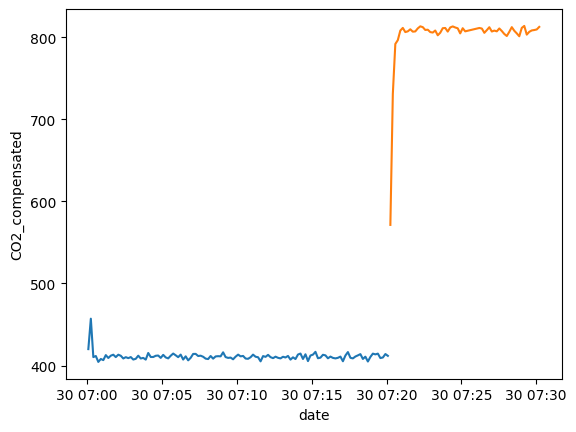

In [100]:
# System 1 has bottles 6 & 2

bottles_meas = []

df_f = df.filter(pl.col("gas_bottle_id") == "6").filter(pl.col("CO2_compensated") > 0)
avg = df_f["CO2_compensated"][(int(len(df_f)*0.5)):(int(len(df_f)*0.95))].mean()
bottles_meas.append(avg)
print(avg)

sns.lineplot(data=df_f,x='date',y="CO2_compensated")

df_f = df.filter(pl.col("gas_bottle_id") == "2").filter(pl.col("CO2_compensated") > 0)
avg = df_f["CO2_compensated"][(int(len(df_f)*0.3)):(int(len(df_f)*0.95))].mean()
bottles_meas.append(avg)
print(avg)
sns.lineplot(data=df_f,x='date',y="CO2_compensated")

In [101]:
def two_point_calibration(measured_values, true_values):
    # Check if input lists have length 2
    if len(measured_values) != 2 or len(true_values) != 2:
        raise ValueError("Both measured_values and true_values must have length 2")

    # Calculate calibration parameters (slope and intercept)
    slope = (true_values[1] - true_values[0]) / (measured_values[1] - measured_values[0])
    intercept = true_values[0] - slope * measured_values[0]

    return slope, intercept

In [188]:
bottle_true = [df_gas.filter(pl.col("Bottle_ID")== 6)["CO2_dry"][0],df_gas.filter(pl.col("Bottle_ID")== 2)["CO2_dry"][0]]

slope, intercept = two_point_calibration(bottles_meas, bottle_true)
print(slope, intercept)


1.0201235376856512 -17.189192149753637


In [191]:
df_meas = df.filter(pl.col("variant") == "measurement").filter(pl.col("system name") == "tum-esm-midcost-raspi-5").filter(pl.col("CO2_compensated") > 0).filter(pl.col("CO2_compensated") < 600).sort("date").groupby_dynamic("date",every='10m').agg(pl.all().exclude('date').mean())

df_meas = df_meas.with_columns(pl.col("CO2_compensated") - intercept / slope)

df_meas.tail()

date,system name,variant,CO2_raw,CO2_compensated,CO2_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,chamber_temperature,gas_bottle_id
"datetime[μs, UTC]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
2023-07-30 23:10:00 UTC,null,null,373.835088,417.204494,400.354386,49.624386,48.880702,948.867895,20.714386,20.64807,22.540351,null
2023-07-30 23:20:00 UTC,null,null,374.411667,417.853442,401.003333,49.657667,48.9035,948.882833,20.640167,20.571333,22.441667,null
2023-07-30 23:30:00 UTC,null,null,377.836667,421.253442,404.403333,50.824167,50.01,948.939,20.5645,20.498333,22.396667,null
2023-07-30 23:40:00 UTC,null,null,380.551667,424.091775,407.241667,51.938667,51.096,948.988,20.484,20.419833,22.321667,null
2023-07-30 23:50:00 UTC,null,null,378.973684,422.241336,405.391228,52.109649,51.272105,948.671053,20.404561,20.333684,22.214035,null


In [121]:
df_p = pd.read_csv("../data/picarro/CFADS2343-20230730-000014Z-DataLog_User.dat",sep='\s+')
df_p["datetime"] = pd.to_datetime((df_p['DATE'] + ' ' + df_p['TIME']))
df_p.head()

,DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,...,CO2,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime
0,2023-07-30,00:00:00.378,210.000004,5040.000105,211.000004,1.690675e+09,0,963,140.003001,45.00045,...,419.648833,430.502855,2.022647,1181.903298,94.43908,1084.867770,76.205523,-0.074475,-0.04456,2023-07-30 00:00:00.378
1,2023-07-30,00:00:00.884,210.000010,5040.000246,211.000010,1.690675e+09,0,963,140.000793,45.00045,...,419.648833,430.574158,2.023890,1181.903298,94.43908,1084.867770,76.205523,-0.074475,-0.04456,2023-07-30 00:00:00.884
2,2023-07-30,00:00:02.428,210.000028,5040.000675,211.000028,1.690675e+09,0,963,140.007018,45.00045,...,419.648833,430.574158,2.023890,1181.910224,94.43908,1085.042196,76.205523,-0.074465,-0.04455,2023-07-30 00:00:02.428
3,2023-07-30,00:00:03.345,210.000039,5040.000929,211.000039,1.690675e+09,0,963,140.015208,45.00045,...,419.656023,430.574158,2.023890,1181.910224,94.43908,1084.920966,76.205523,-0.074471,-0.04455,2023-07-30 00:00:03.345
4,2023-07-30,00:00:03.851,210.000045,5040.001070,211.000045,1.690675e+09,0,963,140.021429,45.00045,...,419.656023,430.585300,2.023949,1181.910224,94.43908,1084.920966,76.205523,-0.074471,-0.04455,2023-07-30 00:00:03.851


<Axes: xlabel='date', ylabel='CO2_compensated'>

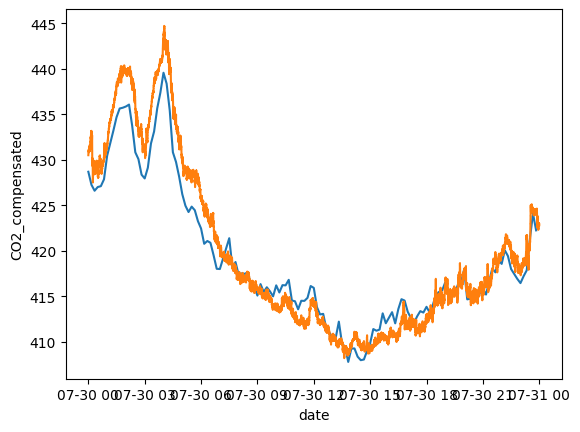

In [192]:
sns.lineplot(data=df_meas,x='date',y="CO2_compensated")
sns.lineplot(data=df_p,x='datetime',y="CO2_dry")